In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `CutOutSemantic` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerRandom, HoleMakerBounded, HoleMakerAttention
from semantic_segmentation_augmentations.holesfilling import CutOutSemantic

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn (x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

def ParentSplitter(x):
    return Path(x).parent.name==test_name

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

In order to know how does this technique work, we can show an example:

This technique cuts a random selected region of the image and removes a specified class inside it. The other information inside the region is not removed. The occlusion class can be randomly selected each time using the '-1' class.

Another `HoleMakerTechnique` can be selected to select the region, such as `HoleMakerBounded` or `HoleMakerAttention`.

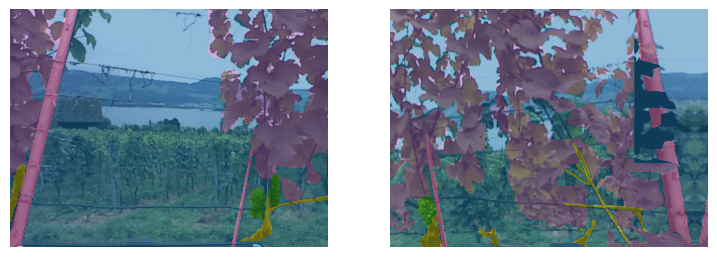

In [ ]:
cos = CutOutSemantic(holes_num = 1, occlusion_class = 2, hole_maker = HoleMakerRandom((250, 250)))
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cos) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cos.x, cos.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for holes_num in [1, 2]:
    for size in [(150, 150), (250, 250)]:
        for holemaker in [HoleMakerBounded, HoleMakerAttention]:
            cos = CutOutSemantic(holes_num = holes_num, hole_maker = holemaker(hole_size = size))
            learner_hparams["cbs"] = [esc, cos]
            r = evaluate(db_hparams,
                         dls_hparams,
                         technique,
                         learner_hparams,
                         learning_hparams,
                         learning_mode
                        )
            results.update({
                str(holes_num) + str(size) + str(holemaker).split("'")[1].split(".")[2]: r["DiceMulti"]
            })

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,0.981287,0.586610,0.344549,00:21
1,0.655533,0.423140,0.498116,00:20
2,0.701629,0.842951,0.285370,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.510822,0.393706,0.369680,00:20
1,0.460199,0.347708,0.449162,00:20
2,0.425403,0.358371,0.604049,00:20
3,0.388380,0.330385,0.592391,00:20
4,0.369890,0.338278,0.673198,00:20
5,0.376365,0.290811,0.738305,00:20
6,0.358295,0.294132,0.684526,00:20
7,0.331893,0.442248,0.631431,00:20
8,0.319818,0.321710,0.742135,00:20
9,0.308510,0.291641,0.727612,00:20


No improvement since epoch 21: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.913921,0.641903,0.340501,00:20
1,0.674058,0.488969,0.343691,00:21
2,1.005432,0.969543,0.204597,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.552741,0.408142,0.413760,00:21
1,0.461214,0.375711,0.530442,00:21
2,0.423629,0.352553,0.552529,00:21
3,0.397427,0.326509,0.679043,00:21
4,0.372655,0.313693,0.698670,00:21
5,0.349280,0.294329,0.722446,00:20
6,0.327587,0.323138,0.749067,00:21
7,0.311911,0.292558,0.786436,00:21
8,0.300886,0.294988,0.770488,00:20
9,0.294053,0.316585,0.754529,00:20


No improvement since epoch 12: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.012169,0.844442,0.262549,00:20
1,0.718644,0.419346,0.347951,00:20
2,0.579926,0.474604,0.551128,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.374281,0.341860,0.642789,00:21
1,0.343141,0.315705,0.717724,00:20
2,0.327088,0.337816,0.741453,00:21
3,0.307386,0.272599,0.786293,00:21
4,0.296458,0.308597,0.766791,00:21
5,0.291521,0.271485,0.793530,00:21
6,0.283713,0.269573,0.792118,00:21
7,0.297566,0.299120,0.785664,00:21
8,0.288684,0.267842,0.794594,00:20


No improvement since epoch 3: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.914555,0.595176,0.338735,00:20
1,0.692105,0.442610,0.350694,00:20
2,0.597875,0.343830,0.501035,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.395992,0.272919,0.640231,00:21
1,0.363021,0.251786,0.728706,00:20
2,0.337887,0.248893,0.782668,00:20
3,0.323666,0.239328,0.792956,00:21
4,0.314280,0.307636,0.781876,00:21
5,0.321831,0.263346,0.759655,00:21
6,0.323153,0.229223,0.799527,00:21
7,0.302839,0.219569,0.826185,00:21
8,0.286164,0.218214,0.838359,00:21
9,0.282765,0.244905,0.760463,00:21


No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.891769,0.572210,0.348000,00:20
1,0.634576,0.623206,0.322113,00:20
2,0.666140,1.034468,0.134681,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.509866,0.443127,0.483964,00:21
1,0.428287,0.354584,0.558288,00:21
2,0.375761,0.308931,0.687691,00:20
3,0.347468,0.294270,0.730677,00:21
4,0.327305,0.361436,0.716515,00:20
5,0.326155,0.291023,0.706944,00:20
6,0.318403,0.343538,0.767432,00:21
7,0.302188,0.316114,0.742311,00:20
8,0.284802,0.266573,0.802421,00:21
9,0.266441,0.320724,0.813605,00:20


No improvement since epoch 18: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.876041,0.535473,0.331942,00:20
1,0.656451,0.633912,0.364714,00:20
2,17.643213,0.892983,0.218606,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.597941,0.547466,0.332014,00:21
1,0.488708,0.490048,0.405263,00:20
2,0.414626,0.441599,0.541605,00:20
3,0.370854,0.597799,0.530346,00:20
4,0.336845,0.633324,0.619095,00:20
5,0.309524,0.401558,0.682168,00:20
6,0.287800,0.531936,0.691990,00:20
7,0.284535,0.389923,0.708987,00:20
8,0.266939,0.506792,0.697235,00:20
9,0.257063,0.529914,0.717534,00:20


No improvement since epoch 7: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.004559,0.699683,0.328847,00:20
1,0.718051,0.472279,0.376756,00:20
2,0.646320,0.737821,0.256738,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.461867,0.412558,0.477843,00:21
1,0.399516,0.342198,0.547083,00:21
2,0.374318,0.303070,0.743383,00:20
3,0.344069,0.271072,0.767530,00:20
4,0.326896,0.269582,0.759004,00:21
5,0.319259,0.273674,0.766756,00:21
6,0.314448,0.280814,0.794196,00:21
7,0.296041,0.256473,0.790312,00:24
8,0.280845,0.296911,0.763193,00:24
9,0.282692,0.266016,0.815086,00:24


No improvement since epoch 12: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.916381,0.632257,0.327551,00:22
1,0.740993,0.465587,0.351540,00:22
2,0.609749,0.388125,0.470849,00:26


epoch,train_loss,valid_loss,dice_multi,time
0,0.378340,0.333827,0.622285,00:27
1,0.335992,0.311638,0.705879,00:25
2,0.317610,0.352279,0.695133,00:24
3,0.327608,0.323248,0.740051,00:24
4,0.314367,0.287852,0.787486,00:23
5,0.293853,0.306792,0.776818,00:23
6,0.300690,0.306529,0.791208,00:23
7,0.305135,0.283022,0.729403,00:22
8,0.282764,0.269245,0.807098,00:24
9,0.266697,0.275516,0.759290,00:23


No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.878371,0.741737,0.306281,00:21
1,0.626457,0.366117,0.427901,00:21
2,1.655223,17.793053,0.139430,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,3.265064,0.379834,0.450817,00:20
1,1.411710,0.293993,0.576487,00:21
2,0.836144,0.256545,0.718658,00:22
3,0.578942,0.243197,0.768921,00:24
4,0.458873,0.310934,0.590489,00:22
5,0.412849,0.279797,0.771642,00:21
6,0.375451,0.276271,0.744755,00:21
7,0.347498,0.219939,0.814829,00:23
8,0.329010,0.293646,0.797721,00:24
9,0.313900,0.230641,0.820852,00:24


No improvement since epoch 7: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.052686,0.663427,0.332242,00:21
1,0.687755,0.395177,0.357349,00:23
2,0.690875,3.067560,0.118273,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.892605,0.477361,0.347838,00:23
1,0.595775,0.429726,0.527292,00:23
2,0.469182,0.387477,0.591641,00:23
3,0.403161,0.307769,0.689887,00:21
4,0.366587,0.338946,0.711281,00:24
5,0.337864,0.291701,0.733084,00:26
6,0.321070,0.262626,0.795322,00:24
7,0.309231,0.286388,0.760170,00:23
8,0.295601,0.261903,0.815943,00:23
9,0.284636,0.269083,0.795308,00:22


No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.398753,0.861085,0.253568,00:21
1,0.838170,0.565922,0.374665,00:21
2,0.659963,0.814889,0.310254,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.428149,0.475269,0.481444,00:23
1,0.372944,0.422991,0.605074,00:23
2,0.345399,0.419920,0.642125,00:24
3,0.313465,0.411317,0.650519,00:24
4,0.314945,0.385794,0.684189,00:24
5,0.291734,0.379861,0.671469,00:21
6,0.274107,0.552766,0.624997,00:20
7,0.266306,0.406206,0.704675,00:22
8,0.269081,0.414193,0.608859,00:21
9,0.253831,0.393649,0.735030,00:21


No improvement since epoch 4: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.915048,0.782624,0.324395,00:23
1,0.733444,0.526833,0.349793,00:23
2,0.641392,0.719293,0.345758,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,0.447600,0.355217,0.519026,00:21
1,0.389245,0.325301,0.601341,00:21
2,0.369147,0.316229,0.604989,00:23
3,0.348103,0.288266,0.782663,00:24
4,0.330291,0.263835,0.761254,00:24
5,0.315510,0.271869,0.769721,00:24
6,0.311238,0.282474,0.756234,00:23
7,0.303361,0.285888,0.794806,00:23
8,0.293830,0.293059,0.795680,00:23
9,0.296384,0.263822,0.783107,00:22


No improvement since epoch 4: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.296957,0.703753,0.320319,00:23
1,0.874070,0.458674,0.351055,00:23
2,0.668322,0.448323,0.480750,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.381380,0.362899,0.575886,00:24
1,0.357446,0.315810,0.730841,00:24
2,0.354685,0.332215,0.704117,00:24
3,0.336336,0.340192,0.688231,00:24
4,0.350657,0.324995,0.626475,00:23
5,0.324522,0.284861,0.769708,00:23
6,0.302183,0.276176,0.782363,00:21
7,0.293431,0.284301,0.775387,00:24
8,0.285716,0.282548,0.795514,00:24
9,0.276234,0.393072,0.773699,00:23


No improvement since epoch 10: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.849937,0.527730,0.356763,00:24
1,0.597642,0.357578,0.466131,00:24
2,1.384561,0.914164,0.222944,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.660815,0.434931,0.355028,00:23
1,0.522123,0.355235,0.360026,00:23
2,0.456650,0.284965,0.546145,00:22
3,0.407344,0.294459,0.676996,00:21
4,0.370200,0.252155,0.751035,00:21
5,0.352313,0.229030,0.815626,00:24
6,0.330082,0.269750,0.784101,00:22
7,0.317140,0.230099,0.798809,00:22
8,0.299568,0.213839,0.826916,00:23
9,0.288228,0.258914,0.794258,00:24


No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.262967,0.806421,0.281688,00:24
1,0.802481,0.577172,0.371193,00:24
2,0.656642,0.640522,0.335265,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.401441,0.375905,0.583748,00:24
1,0.362816,0.335269,0.606485,00:24
2,0.344015,0.321907,0.713472,00:24
3,0.322994,0.303077,0.719176,00:24
4,0.326400,0.267854,0.770214,00:25
5,0.306142,0.262539,0.800632,00:24
6,0.300667,0.292012,0.780337,00:25
7,0.309601,0.273066,0.762915,00:25
8,0.295737,0.268542,0.780001,00:24
9,0.281397,0.281417,0.807465,00:22


No improvement since epoch 4: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.930700,0.648060,0.308888,00:27
1,0.652660,0.688752,0.374766,00:25
2,0.574802,0.596385,0.433355,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.365781,0.453667,0.577260,00:22
1,0.330216,0.378334,0.655038,00:24
2,0.310908,0.438904,0.643874,00:24
3,0.297480,0.438728,0.673777,00:24
4,0.275281,0.435842,0.703099,00:24
5,0.272414,0.383008,0.692687,00:24
6,0.262208,0.401687,0.711147,00:24


No improvement since epoch 1: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.995397,0.639552,0.336488,00:23
1,0.730617,0.557566,0.341942,00:22
2,0.602342,0.398858,0.484451,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.384767,0.328488,0.557841,00:21
1,0.359291,0.303826,0.683466,00:26
2,0.333866,0.287010,0.718077,00:24
3,0.319000,0.280796,0.732916,00:22
4,0.313642,0.286052,0.761299,00:23
5,0.323908,0.307716,0.734151,00:24
6,0.307604,0.254413,0.796486,00:25
7,0.310855,0.277548,0.732407,00:25
8,0.289277,0.259529,0.807430,00:25
9,0.283259,0.273938,0.792681,00:24


No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.059118,0.816624,0.240671,00:24
1,0.806268,0.627963,0.316832,00:24
2,0.982171,0.783143,0.292067,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.535693,0.455237,0.348587,00:24
1,0.478568,0.380710,0.411738,00:23
2,0.433570,0.354580,0.355712,00:23
3,0.397888,0.338273,0.665985,00:23
4,0.375276,0.319833,0.510544,00:23
5,0.367914,0.317004,0.691797,00:23
6,0.344158,0.294950,0.743310,00:22
7,0.327953,0.328304,0.741831,00:22
8,0.313060,0.290690,0.742037,00:22
9,0.303353,0.284664,0.742846,00:22


No improvement since epoch 15: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.938956,0.528279,0.347995,00:23
1,0.660738,0.370186,0.362987,00:22
2,0.723010,0.721251,0.287935,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,0.552692,0.361522,0.524741,00:23
1,0.461536,0.301592,0.507425,00:23
2,0.409530,0.259880,0.633010,00:23
3,0.372675,0.265364,0.680685,00:24
4,0.350446,0.258361,0.766179,00:25
5,0.332899,0.252750,0.687584,00:25
6,0.327681,0.231326,0.807342,00:25
7,0.310201,0.221053,0.803563,00:24
8,0.301517,0.273917,0.748069,00:25
9,0.289103,0.221329,0.819906,00:25


No improvement since epoch 16: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.085845,0.653144,0.313667,00:22
1,0.749518,0.537016,0.351014,00:22
2,0.593909,0.631823,0.452039,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,0.360869,0.310617,0.731548,00:22
1,0.365332,0.331109,0.729220,00:22
2,0.341596,0.285618,0.768386,00:25
3,0.318478,0.312943,0.726033,00:25
4,0.311675,0.266492,0.764626,00:24
5,0.303048,0.299971,0.726553,00:24
6,0.305704,0.266275,0.799771,00:25
7,0.298644,0.285095,0.745053,00:26
8,0.286558,0.248100,0.808912,00:25
9,0.284591,0.247348,0.830998,00:25


No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.874017,0.653349,0.311972,00:21
1,0.617027,0.616493,0.353990,00:21
2,0.583339,0.504340,0.332459,00:23


epoch,train_loss,valid_loss,dice_multi,time
0,0.432230,0.437150,0.460851,00:24
1,0.371928,0.461367,0.595404,00:24
2,0.327484,0.403635,0.665642,00:24
3,0.312991,0.455224,0.660999,00:24
4,0.296083,0.561864,0.672418,00:24
5,0.284459,0.453577,0.697558,00:24
6,0.264187,0.425244,0.727584,00:25
7,0.253606,0.383753,0.705140,00:23
8,0.252011,0.397487,0.717577,00:23
9,0.242732,0.391947,0.693144,00:24


No improvement since epoch 7: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.074994,0.956588,0.296669,00:24
1,0.805414,0.563965,0.334134,00:24
2,0.659396,1.086171,0.187792,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.537899,0.411766,0.479984,00:23
1,0.437942,0.354219,0.562592,00:26
2,0.387148,0.306370,0.623609,00:27
3,0.363790,0.298126,0.722559,00:26
4,0.355521,0.289699,0.745883,00:25
5,0.341477,0.293366,0.726366,00:24
6,0.322982,0.278558,0.805627,00:22
7,0.308327,0.261385,0.791630,00:23
8,0.289752,0.267704,0.781266,00:24
9,0.287939,0.289217,0.778798,00:24


No improvement since epoch 10: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.135615,0.752253,0.314493,00:21
1,0.816952,0.504782,0.351142,00:24
2,0.929060,0.879335,0.214762,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,0.550783,0.412967,0.377934,00:22
1,0.484860,0.370095,0.439936,00:22
2,0.435683,0.351521,0.519010,00:23
3,0.404091,0.310677,0.696915,00:24
4,0.368861,0.300700,0.744657,00:24
5,0.334888,0.309410,0.724672,00:24
6,0.330887,0.299176,0.759266,00:24
7,0.346099,0.411137,0.708569,00:24
8,0.334373,0.298011,0.725423,00:24
9,0.298921,0.276581,0.802215,00:24


No improvement since epoch 10: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.922083,0.463276,0.356004,00:22
1,0.628278,0.317160,0.428769,00:21
2,6.527946,19.297045,0.140415,00:25


epoch,train_loss,valid_loss,dice_multi,time
0,4.487590,0.421812,0.359840,00:25
1,1.863422,0.356862,0.360697,00:24
2,1.085022,0.425067,0.426793,00:23
3,0.739878,0.302086,0.569503,00:23
4,0.557017,0.291037,0.701777,00:23
5,0.452949,0.256472,0.743190,00:22
6,0.389098,0.244398,0.750542,00:24
7,0.365532,0.263940,0.781183,00:24
8,0.333998,0.237142,0.799652,00:24
9,0.319443,0.223894,0.822527,00:24


No improvement since epoch 9: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.898200,0.769245,0.281947,00:22
1,0.722373,0.482427,0.351080,00:23
2,0.672723,0.747914,0.294725,00:23


epoch,train_loss,valid_loss,dice_multi,time
0,0.476899,0.429363,0.376004,00:22
1,0.409263,0.362700,0.549490,00:22
2,0.394554,0.380169,0.581298,00:24
3,0.368220,0.349650,0.675913,00:25
4,0.337505,0.309476,0.742069,00:25
5,0.323201,0.275821,0.787822,00:25
6,0.310444,0.326254,0.714203,00:24
7,0.313343,0.269916,0.784588,00:23
8,0.294074,0.266203,0.801284,00:22
9,0.282401,0.281573,0.750147,00:23


No improvement since epoch 10: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.025865,0.778304,0.274340,00:23
1,0.698737,0.538593,0.324732,00:22
2,0.584031,0.764019,0.403716,00:25


epoch,train_loss,valid_loss,dice_multi,time
0,0.344170,0.470404,0.564482,00:25
1,0.322723,0.563395,0.624856,00:24
2,0.295141,0.387465,0.681605,00:24
3,0.280339,0.385182,0.686956,00:24
4,0.270330,0.408468,0.700535,00:23
5,0.266067,0.370329,0.706100,00:22
6,0.258561,0.459014,0.700825,00:23
7,0.257918,0.492088,0.652049,00:25
8,0.245755,0.362580,0.722856,00:24
9,0.259896,0.439262,0.683505,00:24


No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.297096,0.636400,0.333880,00:24
1,0.754658,0.375632,0.355944,00:24
2,0.808601,0.901623,0.144237,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.559687,0.429070,0.398695,00:24
1,0.459285,0.372242,0.575507,00:24
2,0.409461,0.310870,0.591709,00:23
3,0.370813,0.334055,0.681897,00:22
4,0.344291,0.273012,0.790596,00:22
5,0.326957,0.285098,0.749990,00:23
6,0.310899,0.279422,0.783859,00:24
7,0.318127,0.265974,0.781299,00:24
8,0.294808,0.267608,0.801639,00:24
9,0.284307,0.303009,0.800345,00:24


No improvement since epoch 4: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.014310,0.720446,0.304657,00:23
1,0.669132,0.423090,0.355732,00:24
2,0.723711,0.543511,0.337191,00:23


epoch,train_loss,valid_loss,dice_multi,time
0,0.458274,0.371099,0.392693,00:23
1,0.395731,0.324487,0.582573,00:24
2,0.378103,0.340297,0.644459,00:24
3,0.357024,0.310514,0.725676,00:24
4,0.335421,0.296137,0.768268,00:24
5,0.312032,0.283660,0.781117,00:23
6,0.294264,0.265180,0.801078,00:22
7,0.301514,0.347391,0.759705,00:25
8,0.310750,0.333808,0.696194,00:26
9,0.289598,0.270314,0.799114,00:24


No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.965515,0.602628,0.347217,00:23
1,0.676891,0.392356,0.417337,00:23
2,3.176225,4.059659,0.116104,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,0.922945,0.408800,0.359068,00:23
1,0.627354,0.343235,0.409519,00:23
2,0.511189,0.333930,0.459823,00:24
3,0.438230,0.261360,0.635188,00:24
4,0.390096,0.280609,0.784143,00:24
5,0.356377,0.253513,0.732301,00:24
6,0.337881,0.243529,0.801906,00:25
7,0.324851,0.230743,0.797007,00:24
8,0.327217,0.238293,0.809135,00:24
9,0.310996,0.259637,0.733798,00:22


No improvement since epoch 10: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.801891,0.620493,0.343651,00:23
1,0.634948,0.699360,0.260596,00:24
2,1.159803,0.853411,0.300210,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.562725,0.483949,0.354968,00:24
1,0.476857,0.407221,0.355521,00:23
2,0.431297,0.359119,0.549960,00:23
3,0.395080,0.322729,0.590707,00:23
4,0.364077,0.358426,0.580593,00:24
5,0.346693,0.294505,0.762212,00:24
6,0.327023,0.303770,0.733594,00:24
7,0.306249,0.274032,0.797088,00:24
8,0.299610,0.352193,0.687881,00:24
9,0.294041,0.265310,0.791516,00:23


No improvement since epoch 11: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.955971,0.780944,0.312317,00:22
1,0.665285,0.500615,0.332467,00:23
2,0.525207,0.422258,0.513353,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.351656,0.404924,0.629651,00:24
1,0.347626,0.416870,0.596865,00:25
2,0.315309,0.366607,0.706506,00:25
3,0.286641,0.440219,0.660722,00:25
4,0.270836,0.381735,0.705498,00:25
5,0.257994,0.617556,0.665355,00:25
6,0.265842,0.602953,0.631608,00:25
7,0.272819,0.474461,0.719400,00:25


No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.024322,0.678771,0.320808,00:22
1,0.698091,0.474823,0.346198,00:22
2,0.640511,0.541074,0.377338,00:25


epoch,train_loss,valid_loss,dice_multi,time
0,0.425188,0.355304,0.503001,00:23
1,0.379632,0.320655,0.649611,00:23
2,0.371362,0.293847,0.682373,00:24
3,0.347521,0.265976,0.765787,00:25
4,0.327591,0.281745,0.764666,00:26
5,0.305565,0.260734,0.768363,00:25
6,0.314584,0.295468,0.734984,00:26
7,0.303100,0.290948,0.813278,00:25
8,0.297852,0.267410,0.803278,00:26


No improvement since epoch 3: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.990873,0.668733,0.303142,00:25
1,0.704192,0.472209,0.351878,00:24
2,0.687268,0.609604,0.319952,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.473680,0.367604,0.448214,00:25
1,0.401500,0.326913,0.550190,00:25
2,0.386775,0.376481,0.567876,00:25
3,0.352120,0.308230,0.664332,00:25
4,0.343247,0.290039,0.758846,00:24
5,0.326265,0.287717,0.775200,00:24
6,0.300483,0.335741,0.757478,00:24
7,0.295569,0.284149,0.782497,00:25
8,0.299182,0.270549,0.786906,00:25
9,0.281322,0.266394,0.787523,00:24


No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.020103,0.488439,0.352509,00:25
1,0.829570,0.455407,0.352574,00:25
2,0.761839,0.967720,0.236134,00:25


epoch,train_loss,valid_loss,dice_multi,time
0,0.566856,0.400292,0.440883,00:26
1,0.468247,0.311545,0.428007,00:25
2,0.420007,0.286399,0.631239,00:26
3,0.388143,0.267911,0.744716,00:23
4,0.356988,0.264220,0.784283,00:24
5,0.335710,0.316501,0.625328,00:22
6,0.327848,0.282838,0.793338,00:22
7,0.332950,0.261938,0.807836,00:23
8,0.316744,0.231663,0.804169,00:24
9,0.292613,0.218447,0.804851,00:25


No improvement since epoch 13: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.031881,0.841904,0.222439,00:24
1,0.771825,0.673944,0.287615,00:25
2,0.685910,0.582987,0.362216,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.404204,0.437137,0.459371,00:24
1,0.378757,0.379078,0.517502,00:23
2,0.355732,0.304639,0.710406,00:25
3,0.357425,0.303676,0.738139,00:25
4,0.341337,0.308907,0.739879,00:24
5,0.320524,0.275979,0.777493,00:23
6,0.303270,0.268579,0.788735,00:23
7,0.298802,0.301049,0.760975,00:23
8,0.284038,0.250354,0.797629,00:23
9,0.267736,0.257866,0.812765,00:25


No improvement since epoch 13: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.081854,0.843582,0.231629,00:22
1,0.749390,0.647492,0.321543,00:22
2,0.650090,0.575723,0.309566,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,0.394522,0.429614,0.474579,00:23
1,0.360698,0.449639,0.593590,00:25
2,0.339482,0.524282,0.660306,00:25
3,0.308967,0.499082,0.673957,00:25
4,0.303283,0.401308,0.671817,00:25
5,0.285054,0.421118,0.713095,00:25
6,0.275982,0.446706,0.677981,00:24
7,0.274424,0.431802,0.713537,00:25
8,0.257341,0.367065,0.693705,00:24
9,0.242775,0.371643,0.740566,00:24


No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.052125,0.666229,0.333790,00:24
1,0.720752,1.043762,0.146590,00:24
2,0.698203,0.548969,0.336746,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.421954,0.398427,0.398055,00:24
1,0.389928,0.388246,0.574038,00:23
2,0.361239,0.285006,0.702338,00:23
3,0.343950,0.290937,0.729271,00:23
4,0.319155,0.262196,0.744919,00:23
5,0.316475,0.298511,0.777910,00:23
6,0.307019,0.258393,0.780793,00:25
7,0.290939,0.361889,0.670687,00:25
8,0.289545,0.251960,0.785927,00:25
9,0.290031,0.257831,0.789335,00:25


No improvement since epoch 11: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.943739,0.743719,0.320344,00:26
1,0.717216,0.649135,0.323662,00:23
2,0.710796,0.658561,0.288852,00:23


epoch,train_loss,valid_loss,dice_multi,time
0,0.442523,0.407362,0.405681,00:23
1,0.396147,0.330560,0.591254,00:25
2,0.363001,0.346074,0.639998,00:25
3,0.339800,0.319341,0.601618,00:25
4,0.322452,0.362308,0.671581,00:25
5,0.304455,0.286742,0.728142,00:25
6,0.305892,0.323858,0.606403,00:24
7,0.303222,0.296255,0.779893,00:24
8,0.287820,0.333164,0.777138,00:23
9,0.271380,0.264879,0.775808,00:24


No improvement since epoch 9: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.961403,0.455975,0.351210,00:25
1,0.703450,0.634035,0.305874,00:24
2,0.790556,0.878353,0.310399,00:24


epoch,train_loss,valid_loss,dice_multi,time
0,0.524904,0.411754,0.351425,00:23
1,0.467465,0.297360,0.498051,00:23
2,0.407042,0.261666,0.649740,00:23
3,0.375519,0.293176,0.735888,00:23
4,0.360382,0.242050,0.785407,00:24
5,0.327691,0.267993,0.764948,00:25
6,0.323802,0.253016,0.751093,00:25
7,0.322741,0.240698,0.800203,00:26
8,0.319531,0.243268,0.816947,00:26
9,0.308005,0.239826,0.820356,00:25


No improvement since epoch 4: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.916709,0.801476,0.334850,00:23
1,0.683392,0.542049,0.341324,00:24
2,0.647333,0.508145,0.365709,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,0.421757,0.381484,0.397742,00:24
1,0.387841,0.340837,0.588976,00:24
2,0.357896,0.311684,0.721966,00:24
3,0.334021,0.283955,0.733351,00:23
4,0.335225,0.306413,0.671346,00:23
5,0.320453,0.258193,0.809284,00:23
6,0.307896,0.285467,0.713528,00:25
7,0.293602,0.342707,0.786155,00:25
8,0.279953,0.246301,0.825086,00:25
9,0.276469,0.268070,0.798592,00:25


No improvement since epoch 8: early stopping


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,"1(150, 150)HoleMakerBounded","1(150, 150)HoleMakerAttention","1(250, 250)HoleMakerBounded","1(250, 250)HoleMakerAttention","2(150, 150)HoleMakerBounded","2(150, 150)HoleMakerAttention","2(250, 250)HoleMakerBounded","2(250, 250)HoleMakerAttention"
0,0.870399,0.825464,0.841989,0.820704,0.851418,0.822594,0.826041,0.830145
1,0.861599,0.859778,0.806212,0.802679,0.852888,0.803127,0.809105,0.856576
2,0.849347,0.858235,0.855041,0.860161,0.855479,0.849881,0.847796,0.866700
3,0.850660,0.851120,0.838888,0.881890,0.829245,0.863819,0.874326,0.836402
4,0.854580,0.786927,0.778874,0.766880,0.723073,0.801194,0.802797,0.789950


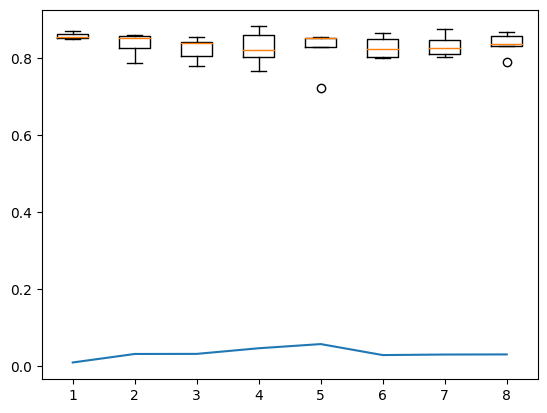

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
"1(150, 150)HoleMakerBounded",0.857317,0.008729
"1(150, 150)HoleMakerAttention",0.836305,0.030851
"1(250, 250)HoleMakerBounded",0.824201,0.031070
"1(250, 250)HoleMakerAttention",0.826463,0.045708
"2(150, 150)HoleMakerBounded",0.822420,0.056521
"2(150, 150)HoleMakerAttention",0.828123,0.027965
"2(250, 250)HoleMakerBounded",0.832013,0.029383
"2(250, 250)HoleMakerAttention",0.835955,0.029668


We save the results in order to plot them together.

In [ ]:
folds = [["COS" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)